# Host and infer

### Create a model from training output

The preceding training job, when complete, will produce a model export into the configured `S3 output path`.  We will now use that output to create a model which can then be hosted by SageMaker.  The creation of a model can be done programmatically using the code below, alternatively you can create a model manually via the SageMaker web console.

From the SageMaker web console `Inference` -> `Model`.  Then click `Create model`.

`Location of inference code image` to a value such as `644912444149.dkr.ecr.eu-west-2.amazonaws.com/xgboost:latest`
`Location of model artifacts` to a value such as `s3://jasbarto-forecast-lab/output/xgboost-forecast-stock-01-copy-2-copy-12-17-copy-12-17/output/model.tar.gz`
Choose `No` to validation of the resource and publishing it to marketplace.



Give the model package a name such as **'xgboost-model-pkg'** and set the `Location of model artifacts` to your output directory.  For example: **`s3://<your-bucket-name>/<your-model-prefix>/output/model.tar.gz`**.  This same value will also be listed in the summary output of the preceding training job.  For the `Location of inference code image` set the value of **'685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:1'**.

Click `Create model`.

In [ ]:
%%time

model_name=job_name + '-model'
print(model_name)

info = client.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

### Create endpoint configuration

SageMaker hosts your model as an endpoint.  This endpoint must be configured with which models you would like it to host.  To create an endpoint configuration you can use the code below to create one programmatically or create one manually via the web console.

From the SageMaker web console click `Endpoint configurations` under `Inference`.  Click `Create endpoint configuration`.

Give your endpoint configuration a name such as 'xgboost-model-endpoint-config' and under 'Production variants' click `Add model`.  Select the model you created in the previous step and click `Create endpoint configuration`.

In [ ]:
endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

### Deploy endpoint

Finally deploy the configured endpoint so that it can be invoked as a secure, RESTful endpoint.  To deploy the endpoint you can use the code below or create a deployment manually via the web console.

From the SageMaker web console click `Endpoints` under `Inference`.  Click `Create endpoint`.  Give your endpoint a name such as `xgboost-endpoint` and select the endpoint configuration created in the previous step.  Click `Deploy endpoint`.

In [ ]:
%%time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

### Invoke the endpoint

Once the SageMaker endpoint has been deployed your trained model is running and ready to perform inference.  Let's test it now using the Boto3 client.

In [ ]:
sm_client = boto3.client('runtime.sagemaker')

In [1]:
!ls data/train/train

2017-08-01-2017-08-31.csv  2017-12-01-2017-12-31.csv  2018-04-01-2018-04-30.csv
2017-09-01-2017-09-30.csv  2018-01-01-2018-01-31.csv  2018-05-01-2018-05-31.csv
2017-10-01-2017-10-31.csv  2018-02-01-2018-02-28.csv  2018-06-01-2018-06-30.csv
2017-11-01-2017-11-30.csv  2018-03-01-2018-03-31.csv  2018-07-01-2018-07-31.csv


In [2]:
!head -n1 data/train/train/2018-07-01-2018-07-31.csv > /tmp/test_data_single.csv

In [13]:
%%time
import json
from itertools import islice
import math
import struct
import boto3

endpoint_name = 'forecast-endpoint'

sm_client = boto3.client ('runtime.sagemaker')

def predict (features):
    response = sm_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=features)
    result = response['Body'].read()
    return result

file_name = '/tmp/test_data_single.csv' #customize to your test file

with open(file_name, 'r') as f:
    payload = f.read().strip()
label, features = payload.split (',', 1)
print ("Label: {}\nPrediction: {}".format (label, predict (features)))

Label: 9.995
Prediction: b'8.73106098175'
CPU times: user 17 ms, sys: 0 ns, total: 17 ms
Wall time: 181 ms


Using the convenience function defined above iterate over the contents of the `test_data.csv` file and record the prediction for each observation.  The first number of every observation is the label for that observation, store the label, along with the prediction to then compare them as a measure of the model's performance.

In [46]:
%%time
test_labels = []
test_predictions = []

file_name = '/tmp/test_data_multiple.csv'
!head -n500 data/train/train/2018-07-01-2018-07-31.csv > {file_name}

with open (file_name, 'r') as f:
    for line in f:
        payload = line.strip ()
        label, features = payload.split (',', 1)
        pred = predict (features)
        test_labels.append (float(label))
        test_predictions.append (float(pred))


CPU times: user 1.12 s, sys: 27.1 ms, total: 1.15 s
Wall time: 4.84 s


Import the `accuracy_score` function from the `sklearn.metrics` module.  Use the `accuracy_score` function to calculate the accuracy of the model against the labels and predictions collected in the previous step.

Next use the `crosstab` function of the Pandas library to produce a formatted table highlighting the number of false positives and false negatives.

In [47]:
data = pd.DataFrame ()
data['True_Y'] = test_labels
data['Pred_Y'] = test_predictions

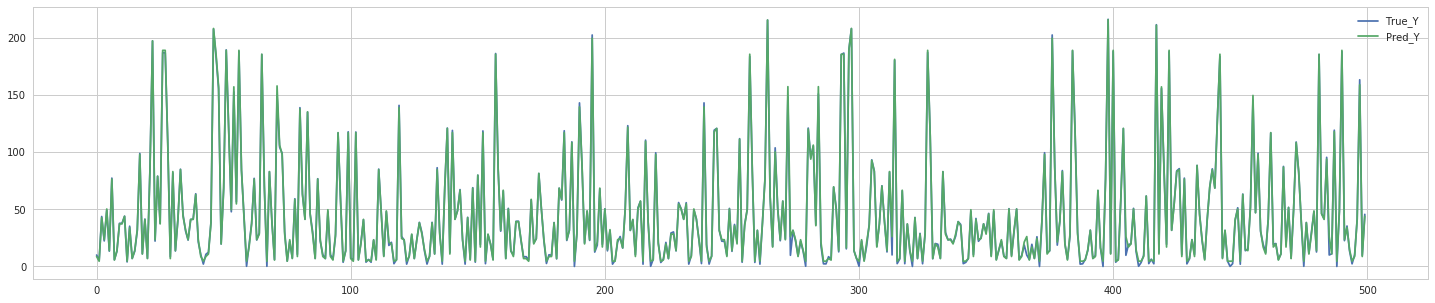

In [48]:
data.plot.line(figsize=(25,5))

In [49]:
from sklearn.metrics import mean_squared_error
print ("RMSE: {}".format (mean_squared_error(test_labels, test_predictions)))

RMSE: 5.007516499852211


In [51]:
print (test_labels[:10])
print (test_predictions[:10])

[9.995, 5.37, 43.72, 22.35, 49.16, 13.44, 77.28, 5.89, 13.28, 37.74]
[8.73106098175, 4.61054992676, 42.7573471069, 23.4016704559, 50.2858161926, 13.8736181259, 76.4500732422, 5.6441321373, 13.8736181259, 37.2606811523]


---
## Complete

That completes this lab.  You should have trained and created a hosted SageMaker model using the XGBoost algorithm for classifying stock movements using sentiment analysis.  The accuracy of your model should have been approximately 52%.  Now think about how you could improve the accuracy of the model.  What are some of the things you could do to perhaps the data, the algorithm, or the algorithm parameters, to tune the performance of your trained model?

### Note: Remove created resources
As part of this lab you will have created an S3 bucket, a SageMaker notebook server, and at least one training job, model, and endpoint.  Please be sure to create each of these to avoid incurring any further charges to your AWS account.